In [7]:
import pandas as pd

# Load the datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')




# Get the number of rows and columns for each DataFrame
rows_columns_X_train = X_train.shape
rows_columns_y_train = y_train.shape

# Output the number of rows and columns
print(f"X_train rows, columns: {rows_columns_X_train}")
print(f"y_train rows, columns: {rows_columns_y_train}")

X_train rows, columns: (10229, 26)
y_train rows, columns: (10229, 3)


In [8]:
# Merge the DataFrames on 'Identifiant'
merged_df = pd.merge(X_train, y_train, on='Identifiant')
merged_df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)
merged_df.to_csv('merged_data.csv', index=False)

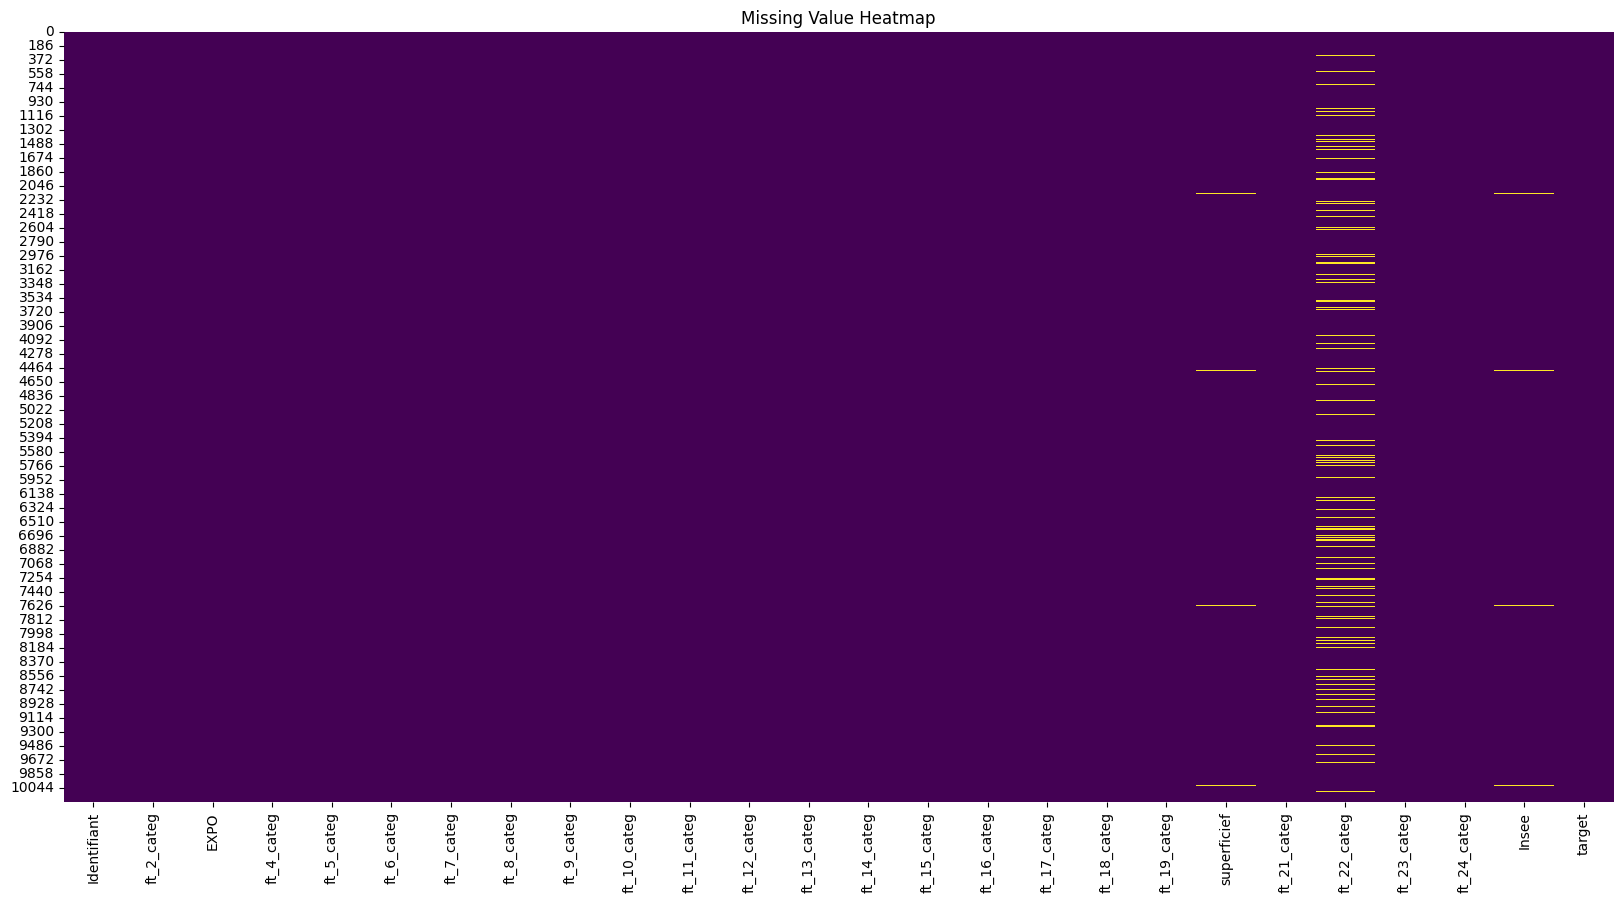

In [9]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your merged DataFrame
# Replace "." with NaN
merged_df = merged_df.replace(".", pd.NA)

# Create a heatmap to visualize missing values
plt.figure(figsize=(20, 10))
sns.heatmap(merged_df.isnull(), cbar=False, cmap='viridis')

plt.title('Missing Value Heatmap')
plt.show()

In [11]:
for col in merged_df.columns:
    if merged_df[col].dtype == 'object':  # Only apply to columns with data type 'object'
        try:
            merged_df[col] = merged_df[col].str.replace(',', '.').astype(float)
        except ValueError:
            pass  # This column might contain non-numeric strings, so we pass


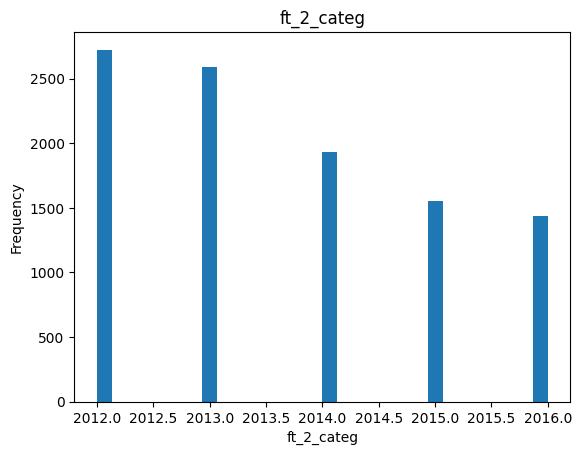

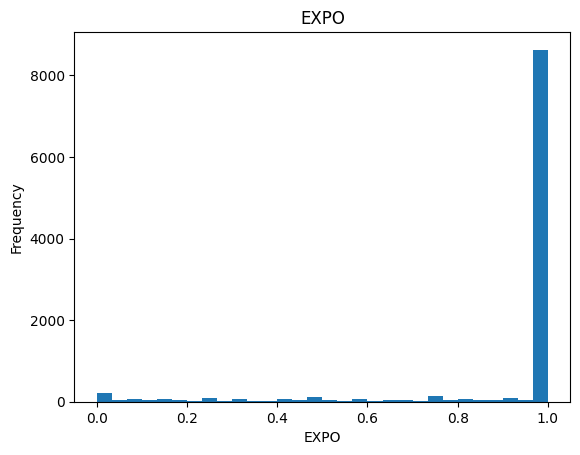

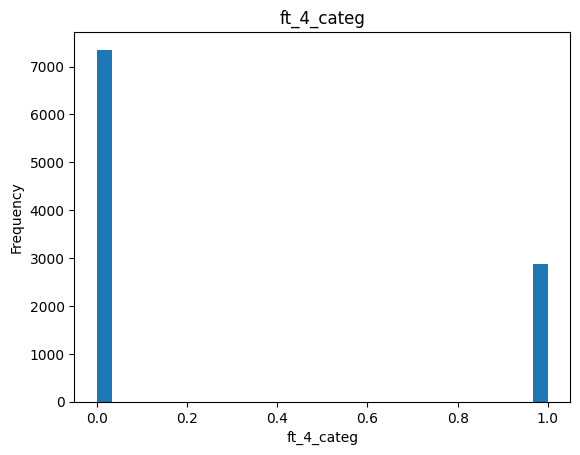

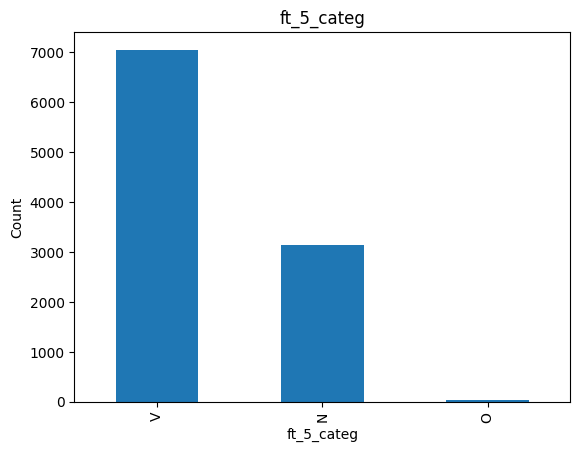

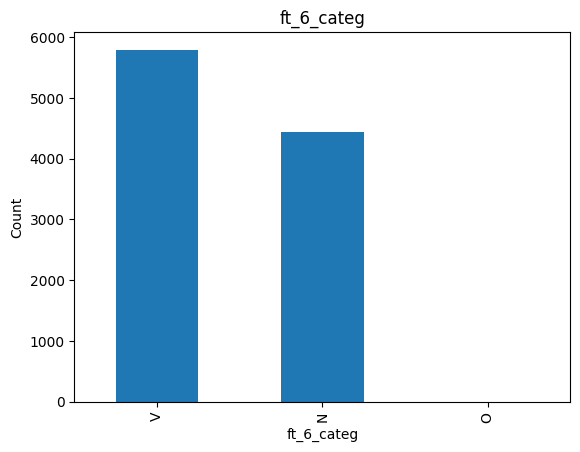

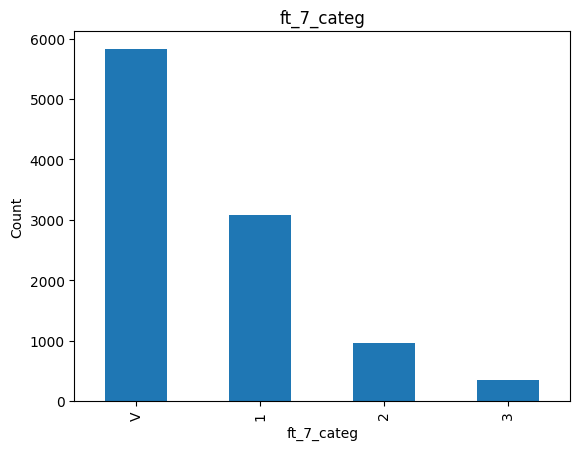

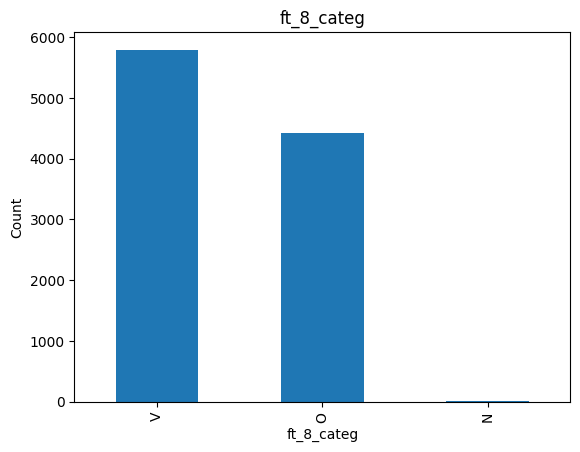

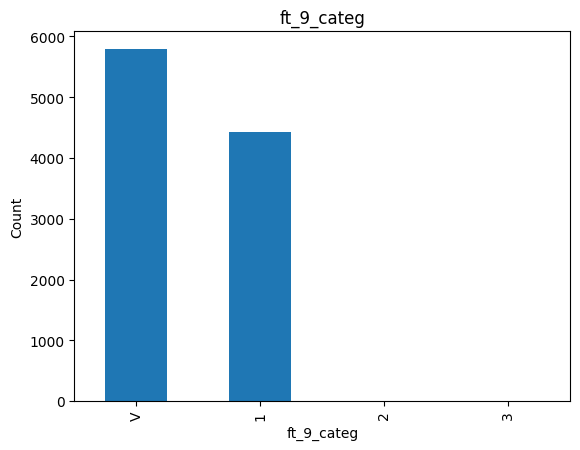

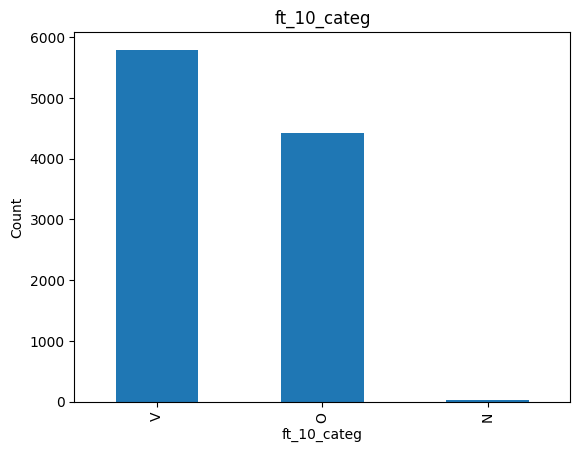

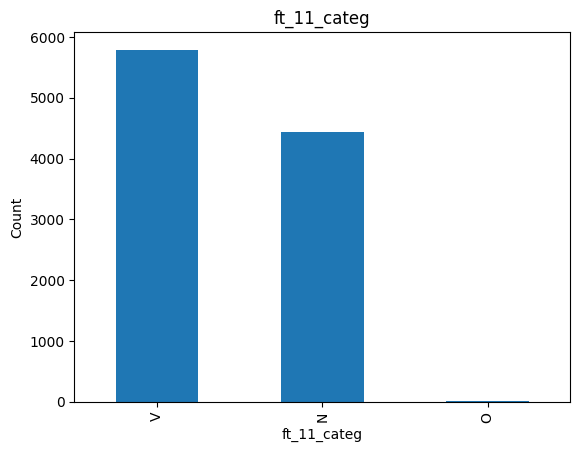

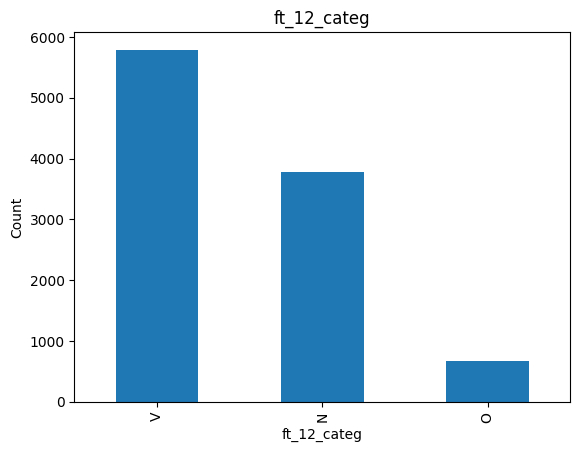

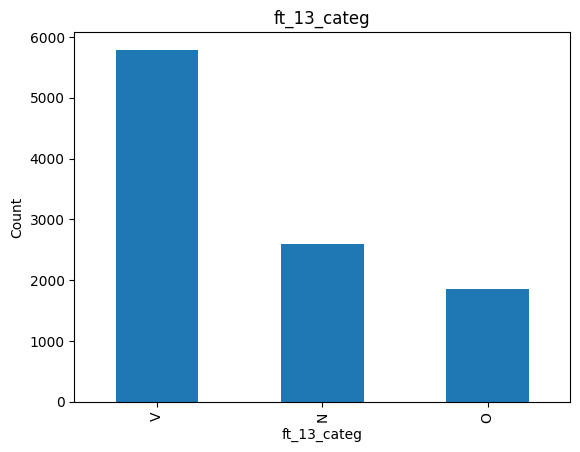

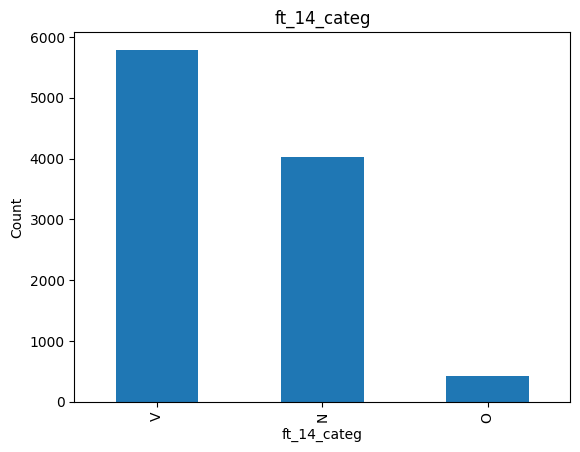

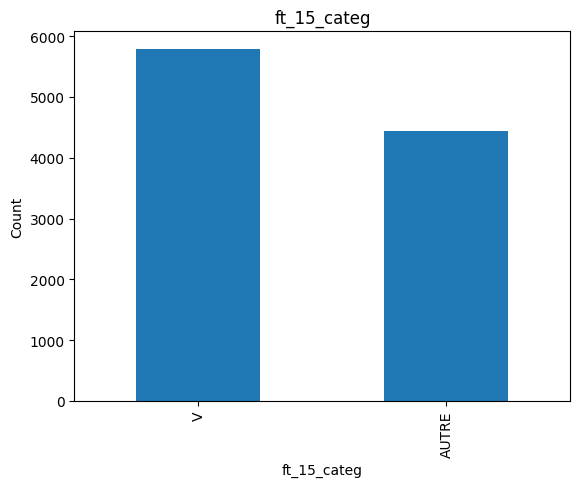

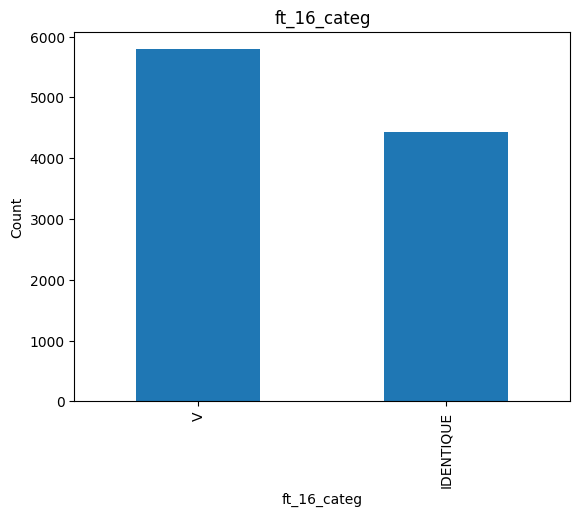

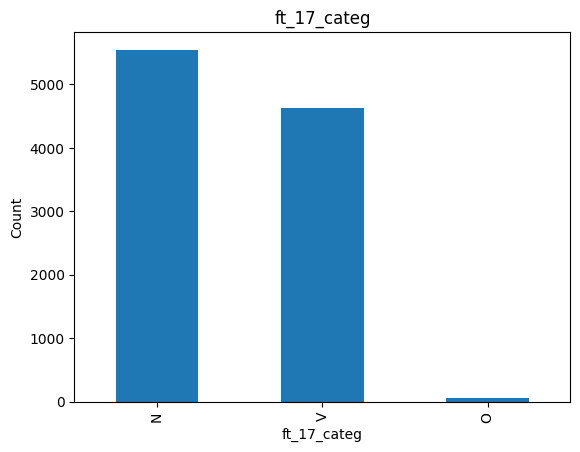

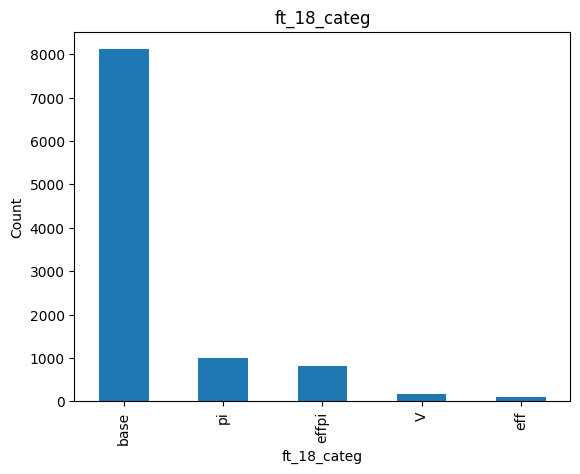

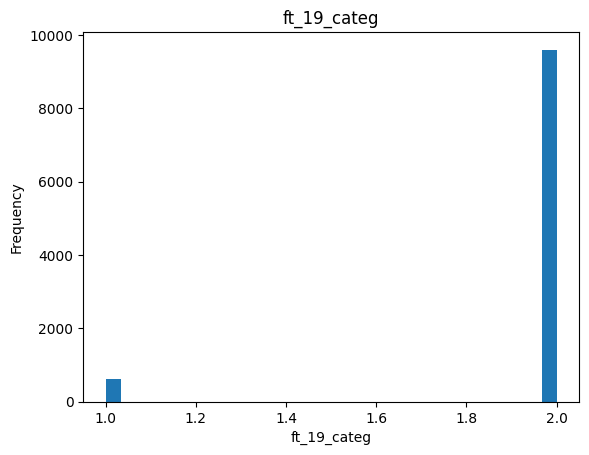

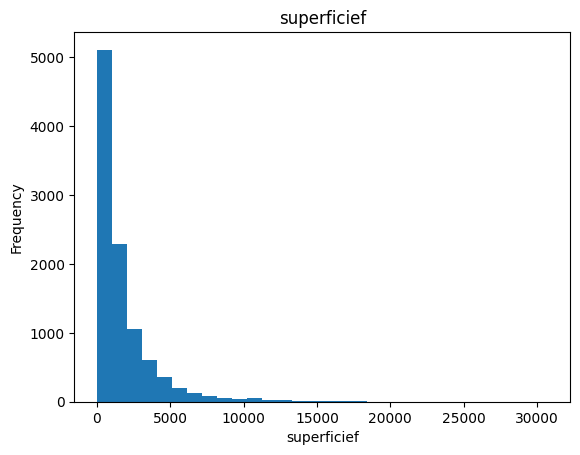

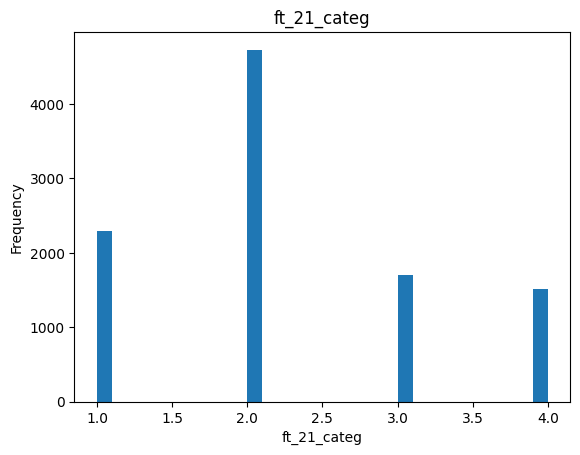

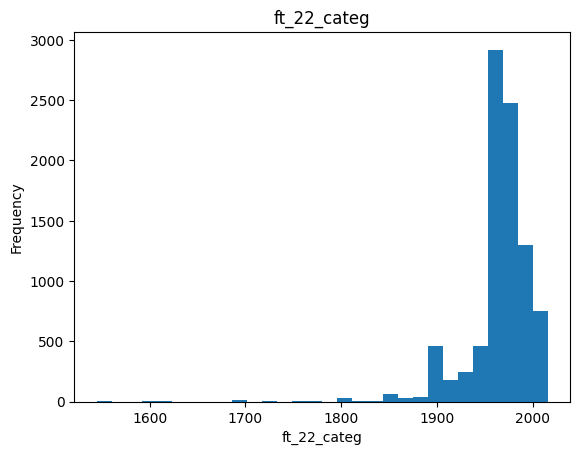

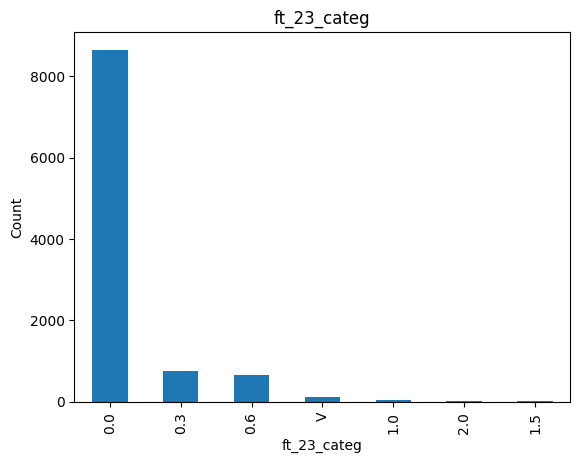

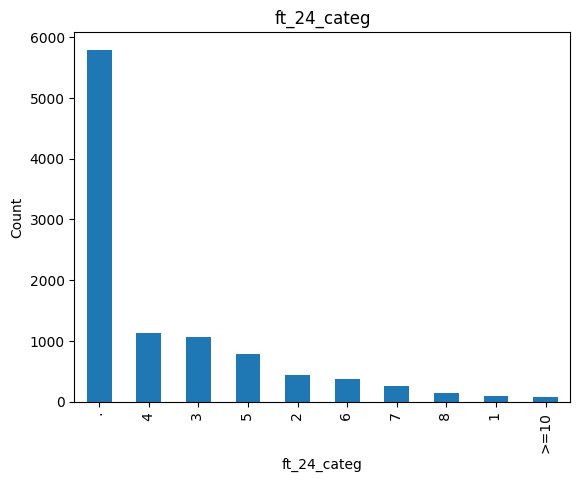

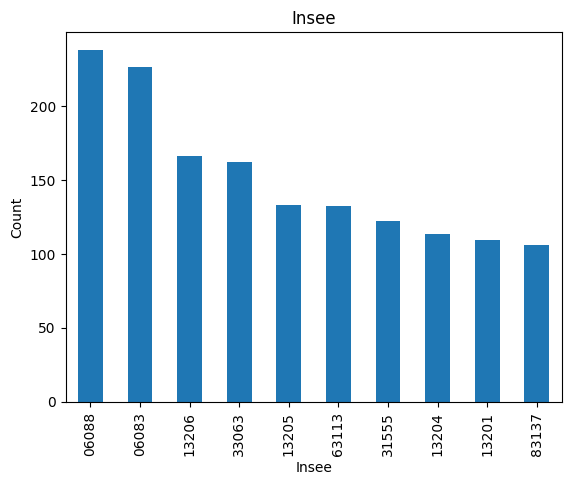

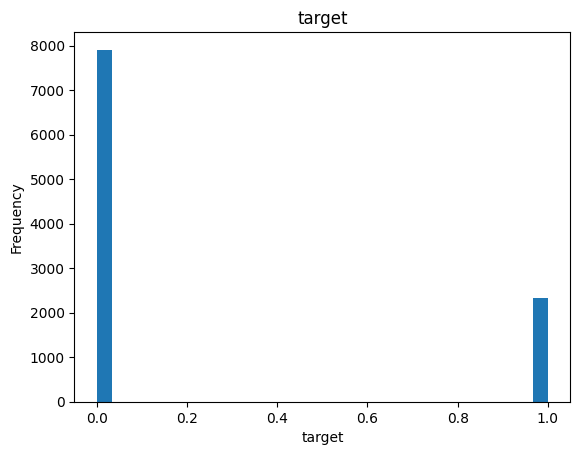

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame

# Iterate through each column in the DataFrame
for column in merged_df.columns:
    # Skip the 'Identifiant' column
    if column == 'Identifiant':
        continue
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(merged_df[column]):
        # Plot histogram for numeric columns
        merged_df[column].plot(kind='hist', bins=30, title=column)
        plt.xlabel(column)
        plt.ylabel('Frequency')
    else:
        # Plot bar chart for categorical columns
        # Because of potentially high cardinality, we limit to the top 10 values
        value_counts = merged_df[column].value_counts().nlargest(10)
        value_counts.plot(kind='bar', title=column)
        plt.xlabel(column)
        plt.ylabel('Count')
    
    plt.show()


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10229 entries, 0 to 10228
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  10229 non-null  int64  
 1   ft_2_categ   10229 non-null  int64  
 2   EXPO         10229 non-null  float64
 3   ft_4_categ   10229 non-null  int64  
 4   ft_5_categ   10229 non-null  object 
 5   ft_6_categ   10229 non-null  object 
 6   ft_7_categ   10229 non-null  object 
 7   ft_8_categ   10229 non-null  object 
 8   ft_9_categ   10229 non-null  object 
 9   ft_10_categ  10229 non-null  object 
 10  ft_11_categ  10229 non-null  object 
 11  ft_12_categ  10229 non-null  object 
 12  ft_13_categ  10229 non-null  object 
 13  ft_14_categ  10229 non-null  object 
 14  ft_15_categ  10229 non-null  object 
 15  ft_16_categ  10229 non-null  object 
 16  ft_17_categ  10229 non-null  object 
 17  ft_18_categ  10229 non-null  object 
 18  ft_19_categ  10229 non-null  int64  
 19  supe

In [16]:
#Checking number of unique rows in each feature

merged_df.nunique().sort_values()

target             2
ft_19_categ        2
ft_4_categ         2
ft_16_categ        2
ft_15_categ        2
ft_17_categ        3
ft_14_categ        3
ft_12_categ        3
ft_11_categ        3
ft_13_categ        3
ft_8_categ         3
ft_6_categ         3
ft_5_categ         3
ft_10_categ        3
ft_9_categ         4
ft_7_categ         4
ft_21_categ        4
ft_18_categ        5
ft_2_categ         5
ft_23_categ        7
ft_24_categ       11
ft_22_categ      139
EXPO             467
Insee           1525
superficief     2463
Identifiant    10229
dtype: int64

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
corr = merged_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()


ValueError: could not convert string to float: 'V'

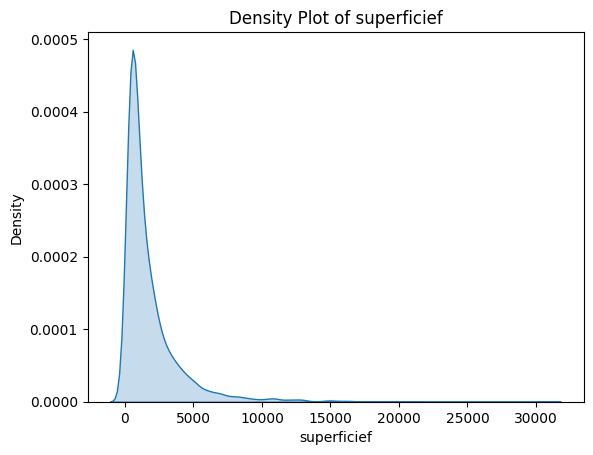

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example for plotting a density plot for a continuous column 'superficief'
sns.kdeplot(merged_df['superficief'], fill=True)
plt.title('Density Plot of superficief')
plt.xlabel('superficief')
plt.ylabel('Density')
plt.show()


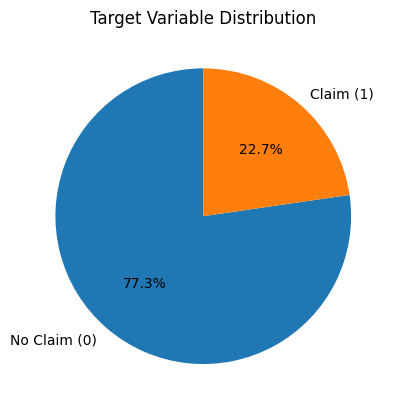

In [19]:
merged_df['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['No Claim (0)', 'Claim (1)'])
plt.title('Target Variable Distribution')
plt.ylabel('')  # Hide the y-label as it's not informative for a pie chart
plt.show()

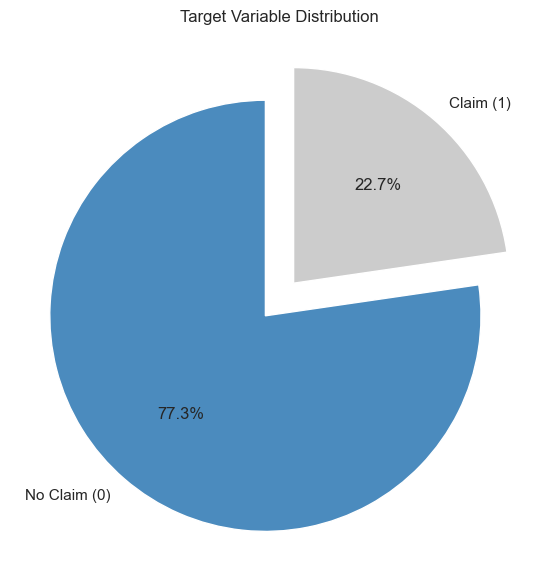

In [29]:
# Apply Seaborn's default styling
sns.set()

# Assuming 'merged_df' is your DataFrame and it has a 'target' column
target_counts = merged_df['target'].value_counts()

# Define labels
labels = ['No Claim (0)', 'Claim (1)']

# Explode settings to separate the slices a bit
explode = (0.1, 0.1)  # Slightly separate the slices

# Create the pie chart with Matplotlib
plt.figure(figsize=(7, 7))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode,
        colors = ['#4B8BBE', '#CCCCCC']  # Darker blue and grey
)

plt.title('Target Variable Distribution')
plt.show()

In [20]:
import pandas as pd

# Assuming 'merged_df' is your DataFrame and 'column_name' is the name of the column you're interested in
unique_values = merged_df['ft_19_categ'].unique()

# Print the unique values
print(unique_values)


[2 1]


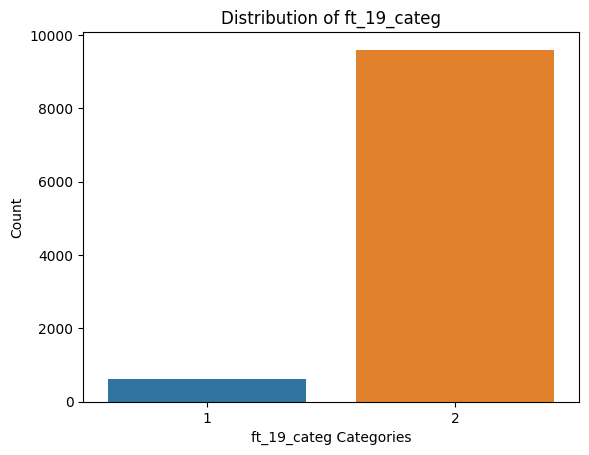

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='ft_19_categ', data=merged_df)
plt.title('Distribution of ft_19_categ')
plt.xlabel('ft_19_categ Categories')
plt.ylabel('Count')
plt.show()


target          0     1
ft_19_categ            
1             558    71
2            7349  2251


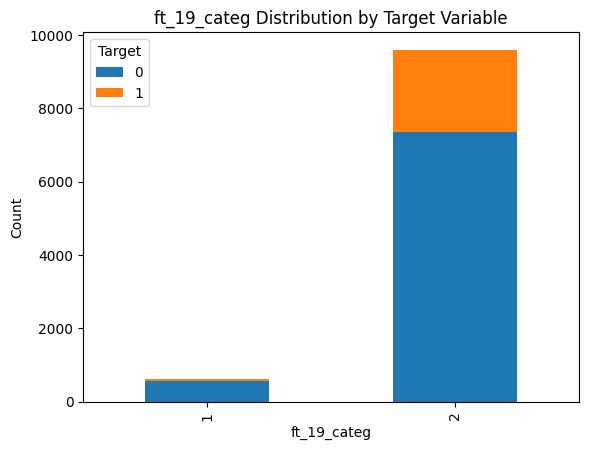

In [22]:
# Crosstab
ct = pd.crosstab(merged_df['ft_19_categ'], merged_df['target'])
print(ct)

# Stacked Bar Plot
ct.plot(kind='bar', stacked=True)
plt.title('ft_19_categ Distribution by Target Variable')
plt.xlabel('ft_19_categ')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()


In [23]:
from scipy.stats import chi2_contingency

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi-square test p-value: {p}")


Chi-square test p-value: 2.4881192683846114e-12
